# Processing Planet imagery

This notebook contains code for processing imagery from Planet Labs. The image files are PlanetScope Analytic SR Ortho Scenes (Product Level 3B) with a 16-bit bit depth. These are the equivalent of raw image files suitable for analytic and scientific analyses. The goal of this notebook is to process these images into tiled RGB image directories suitable for use in generating labeled training data for TensorFlow.

In [1]:
from IPython.display import Image
import rasterio
import skimage
import os
import sys
import pathlib
import math
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
from rasterio.plot import show
from osgeo import gdal

%matplotlib inline

We will start off working with a single image from Ningde, China and then scale up the methods to work with all images

In [78]:
# Load PlanetScope 4-band analytic-sr image
filename = "../img/raw_tiffs/20180331_141443_1010_3B_AnalyticMS_SR.tif"
# Save the image name for later filenaming use
image_name = '20180331_141443_1010_3B_AnalyticMS_SR'

## Loading Images

Now let's open the image using the `rasterio.open` function:

In [79]:
# Load as image raster
imgA = rasterio.open(filename)

## Plotting Images

GeoTiffs can be readily plotted with the `rasterio.plot.show` method after reading the opened GeoTiff file with `read()`. However, the PlanetScope4 3B (analytic SR) scenes have not had a color ramp applied and therefore need to be processed before they can be readily visualized as a RGB image.

For example, consider what happens if no color map is applied prior to plotting:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


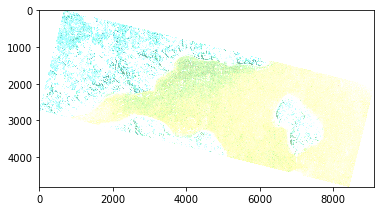

In [80]:
# Plot the second band of the entire image
show(imgA.read())

In this case, pixel values are assumed to be in the 8bit RGB range and are thus clipped to the appropriate range (depending on whether the data type is a `float` or `uint`, see above warning). Because the raw values are outside this range, we get the above uniform image. However, individual bands can be readily plotted because the pixel values for a single band can be normalized.

For example, let's plot the image's red band, which we can do by specifying the band number in the `read` method:

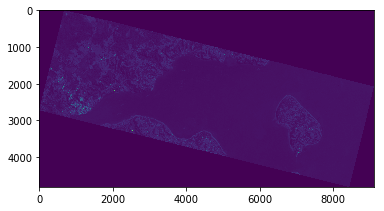

In [81]:
show(imgA.read(2))

In [15]:
imgA.bounds

BoundingBox(left=772959.0, bottom=2946096.0, right=799710.0, top=2958897.0)

### Color Rescaling

To visualize the image as a normal RGB image, we need to rescale the 16bit values down to 8bit. PlanetScope 4-band images also come with the band order blue/green/red/nir, so we need to select and reorder the first three bands to RGB.

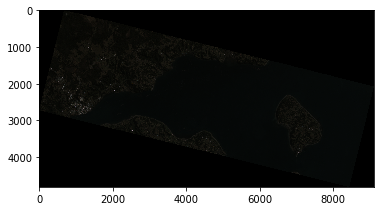

In [82]:
# Scale variable. Note bands of Planet imagery go BGR
imgB = exposure.rescale_intensity(imgA.read((3,2,1)), out_range='uint8')
# Plot image
show(imgB)

Let's try rescaling using the `exposure.equalize_adapthist()` function

(3, 4808, 9121)
1.0
0.0


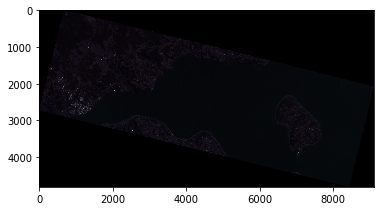

In [83]:
def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_max = arr.max()
    return arr / arr_max

def reorder_to_brg(image):
    '''reorders planet bands to blue, red, green for imshow'''
#     image[:,:,1] = normalize(image[:,:,1])
#     image[:,:,2] = normalize(image[:,:,2])
#     image[:,:,3] = normalize(image[:,:,3])
#     return image
    blue = normalize(image[0,:,:])
    green = normalize(image[1,:,:])
    red = normalize(image[2,:,:])
#     return np.array([blue, red, green])
    return np.stack((blue, red, green), axis=0)

# Read in raw image
imgC = imgA.read((3,2,1))
print(imgC.shape)
imgC = reorder_to_brg(imgC)
# Adaptive Equalization
# imgC = exposure.equalize_hist(imgC)
print(imgC.max())

print(imgC.min())
# Scale variable. Note bands of Planet imagery go BGR
# imgC = exposure.rescale_intensity(imgC, out_range='uint8')

# Plot image
show(imgC)

Let's save a new GeoTiff of this rescaled 8-bit image to use for labeling purposes.

In [21]:
# Get transform of original image
source_transform = imgA.transform
source_crs = imgA.crs

# Open a new GeoTiff data file in which to save the rescaled image
with rasterio.open(('img/rgb_tiffs/' + image_name + '_RGB.tif'), 'w', driver='GTiff',
                       height=imgB.shape[1], width=imgB.shape[2], count=3,
                       dtype=rasterio.ubyte, crs=source_crs, 
                       transform=source_transform) as new_img:
    # Write the rescaled image to the new GeoTiff
    new_img.write(imgB.astype('uint8'))

/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2963: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Now that we've demonstrated converting a single 16-bit PlanetScope scene to a rescaled 8-bit RGB image let's write a function to replicate this process for all PlanetScope scenes in a directory.

In [11]:
def planet_2rgb_8bit(tiff_directory, rgb_directory):
    
    # Get all GeoTiff filnames in specified directory
    files = np.array(os.listdir(tiff_directory))
    tiffs = pd.Series(files).str.contains('.tif')
    files = files[tiffs] 
    
    # Loop over files
    for filename in files:
        print(filename)
        
        # Load as image raster
        imgA = rasterio.open(tiff_directory + filename)        
        # Scale variable. Note bands of Planet imagery go BGR
        imgB = exposure.rescale_intensity(imgA.read((3,2,1)), out_range='uint8')
        # Get image name to use for creating new RGB image
        image_name = filename.split(".tif")[0]
        
        # Open a new GeoTiff data file in which to save the rescaled image
        with rasterio.open((rgb_directory + image_name + '_RGB.tif'), 'w', driver='GTiff',
                       height=imgB.shape[1], width=imgB.shape[2], count=3,
                       dtype=rasterio.ubyte, crs=imgA.crs, 
                       transform=imgA.transform) as new_img:
            # Write the rescaled image to the new GeoTiff
            new_img.write(imgB.astype('uint8'))

planet_2rgb_8bit(tiff_directory = 'img/raw_tiffs/', rgb_directory = 'img/rgb_tiffs/')

20180331_141443_1010_3B_AnalyticMS_SR.tif


/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/ipykernel/__main__.py:27: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
/Users/Tyler-SFG/anaconda/envs/planet/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


20180409_014042_1015_3B_AnalyticMS_SR.tif
20180409_014043_1015_3B_AnalyticMS_SR.tif
20180410_020421_0f31_3B_AnalyticMS_SR.tif
20180510_024305_104e_3B_AnalyticMS_SR.tif


## Windowed Reading/Writing of Images

Many deep learning models are trained on image "chips" of a fixed dimension. As a result, we need to slice our large PlanetScope scenes into numerous chips, which can be accomplished using `rasterio`'s windowed reading functionality.

In [95]:
# Read in a 256x256 subset of the image file
with rasterio.open(filename) as src:
    chip = src.read((3,2,1), window=((2000,2256), (2000,2256)))

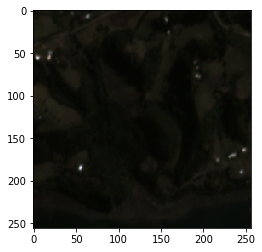

In [91]:
# Scale variable. Note bands of Planet imagery go BGR
chip1 = exposure.rescale_intensity(chip, out_range='uint8')
show(chip1)

1.0


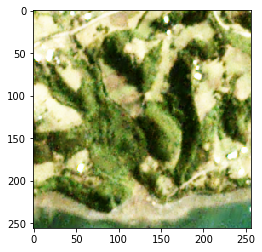

In [96]:
# Normalize bands
# chip2 = reorder_to_brg(chip)
# Histogram Equalization
chip2 = exposure.equalize_hist(chip)
print(chip2.max())
show(chip2)

Now let's build off the above example to divide the image into a grid of 256x256 pixel cells and save each cell as it's own GeoTiff, ignoring cells with missing data on the edge of the image. We write a function that will do the above process for every PlanetScope image in a directory.

In [2]:
# Define a function to create image chips of every GeoTiff file in a directory
def planet2chips(tiff_directory):
    
    # Get all GeoTiff filnames in specified directory
    files = np.array(os.listdir(tiff_directory))
    tiffs = pd.Series(files).str.contains('.tif')
    files = files[tiffs] 
    
    # Loop over files
    for filename in files:
        
        # Get image name to use for creating directory
        image_name = filename.split("_")[0:3]
        image_name = "%s_%s_%s" % (image_name[0], image_name[1], image_name[2])
        
        # Image directory and subdirectories
        image_dir = tiff_directory + image_name + '/'   
        
        chip_dir = image_dir + 'chips/'
        png_dir = image_dir + 'pngs/'
        
        # Print filenames
        print('filename: ' + filename + '\n' + 'image name: ' + image_name)
        
        # Make directories to store raw and rgb image chips
        pathlib.Path(chip_dir).mkdir(parents=True, exist_ok=True)
        pathlib.Path(png_dir).mkdir(parents=True, exist_ok=True)

        # Iterate over image blocks - which are 256x256 - and save new GeoTiffs
        with rasterio.open(tiff_directory + filename) as src:
            # Get block dimensions of src
            for ji, window in src.block_windows(1):
                r = src.read((1,2,3,4), window=window)
                if 0 in r:
                    print("Skipped chip due to missing data.\n")
           
                else:
                    # Scale variable. Note bands of Planet imagery go BGR
                    b = src.read((3,2,1), window=window)
                    b = exposure.rescale_intensity(b, out_range='uint8')
                
                    # Open a new GeoTiff data file in which to save the raw image chip
                    with rasterio.open((chip_dir + image_name + '_' + str(ji[0]) + '_' + str(ji[1]) + '.tif'), 'w', driver='GTiff',
                               height=r.shape[1], width=r.shape[2], count=4,
                               dtype=rasterio.uint16, crs=src.crs, 
                               transform=src.transform) as new_img:
        
                        # Write the raw image to the new GeoTiff
                        new_img.write(r)
                
                    # Open a new PNG data file in which to save the rescaled RGB image chip
                    with rasterio.open((png_dir + image_name + '_' + str(ji[0]) + '_' + str(ji[1]) + '.png'), 'w', driver='PNG',
                               height=r.shape[1], width=r.shape[2], count=3,
                               dtype=rasterio.ubyte, crs=src.crs, 
                               transform=src.transform) as new_img:
        
                        # Write the rescaled image chip to the new PNG
                        new_img.write(b.astype('uint8'))

In [ ]:
# Run function              
planet2chips('img/raw_tiffs/')

## Tiling GeoTiff Images

Individual PlanetScope scenes are very large (4,267 x 8,917 pixels, or 12.8 x 26.75 kilometers) and, in order to see the fine details, we need to be able to zoom in on the image. This is especially important if annotating the images as a whole rather than using individual chips such as created previously. To accomplish this, map services like GoogleEarth and Leaflet use image **tiles**. Essentially, the image is cut into a grid of "tiles" of various sizes that allow map viewers to seamlessly scroll around an image and zoom in/out.  

Creating map tiles from a GeoTiff equates to generating a directory with the tiles for various zoom levels saved in their own subdirectories. This task can be accomplished with the `gdal2tiles.py` function.

Let's now tile the RGB image created above:

In [54]:
# Construct GDAL command
cmd = 'gdal2tiles.py -z 10-16 ' + filename + ' img/tiles/' + image_name

# Run command in the shell
os.system(cmd)

0

The above code demonstrates how to process a single PlanetScope scene and generate a tiled RGB image to use for labeling. Now let's write a function that will do the above process for every PlanetScope image in a directory.

In [ ]:
# Define function that takes a directory of GeoTiffs as an argument and outputs
# an RGB version and a tiled image directory
def planet_2rgb_tiles(tiff_directory):
    
    # Get filenames of GeoTiffs in directory
    files = np.array(os.listdir(tiff_directory))
    tiffs = pd.Series(files).str.contains('.tif')
    files = files[tiffs]
    
    # Loop over files
    for filename in files:
        
        # Get image name to use for creating directory
        image_name = filename.split(".tif")[0]